In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import json

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Serialized Sizes
We recorded the size of the PB / AVRO messages after serialization:

- Simple:
    - Avro: 100018 bytes
    - Protobuf: 100017 bytes
    - Capnproto: 100064
    - Thrift: 100019
- Complex:
    - Avro: 878 bytes
    - Protobuf: 1200 bytes
    - Capnproto: 2848 bytes
    - Thrift: 877 bytes
- Nested:
    - Avro: 100022 bytes
    - Protobuf: 100023 bytes
    - Capnproto: 100088 bytes
    - Thrift: 100031 bytes

# Data Loading

In [2]:
binary_formats = ["PB", 
                  "AVRO", 
                  "CAPNPROTO", 
#                   "AVRO_SCHEMAREG", 
                  "THRIFT"]
message_types = [1, 2, 3]
message_types_string = ["simple", "complex", "nested"]
message_nums = [1000, 
                3000, 
                6000, 
                10000, 
                25000, 
                50000, 
                75000, 
                100000]
consumer_metrics_units = {
    'request-rate': "requests per second",
#     'records-lag-max': "records",
    "outgoing-byte-rate": "bytes per second", # old but newish
    "incoming-byte-rate": "bytes per second", # new
    "bytes-consumed-total": "bytes", # new
    'records-lag-avg': "records",
    'records-consumed-rate': "records per second"
}
producer_metrics_units = {
    'record-send-rate': "records per second", 
#     'request-latency-max': "milliseconds", 
    'request-latency-avg': "milliseconds",
#     'batch-size-avg': "bytes",
#     'record-size-avg': "bytes",
    "buffer-available-bytes": "bytes", # new
    "byte-total": "bytes", # new
#     "bufferpool-wait-time": "milliseconds", # new
}

In [3]:
message_combos = list(itertools.product(message_types, message_nums))
all_dataframes = {}
all_metrics = {}

In [4]:
for bin_type in binary_formats:
    for msg_type, msg_num in message_combos:
        try:
            # Read into dataframe
            df = pd.read_csv(f"data/{bin_type}{msg_type}_{msg_num}_serdes.csv", header=None)

            # Calculate stats
            ser_mean, deser_mean = list(df.mean(axis=0))
            ser_median, deser_median = list(df.median(axis=0))

            ser_10p, deser_10p = list(df.quantile(0.1))
            ser_90p, deser_90p = list(df.quantile(0.9))

            ser_25p, deser_25p = list(df.quantile(0.25))
            ser_75p, deser_75p = list(df.quantile(0.75))
            
            ser_data = list(df[0])
            deser_data = list(df[1])

            # Store
            all_dataframes[(bin_type, msg_type, msg_num)] = {}
            all_dataframes[(bin_type, msg_type, msg_num)]["ser"] = {
                "mean": ser_mean,
                "median": ser_median,
                "data": ser_data,
                "10p": ser_10p,
                "90p": ser_90p,
                "25p": ser_25p,
                "75p": ser_75p,
            }
            all_dataframes[(bin_type, msg_type, msg_num)]["deser"] = {
                "mean": deser_mean,
                "median": deser_median,
                "data": deser_data,
                "10p": deser_10p,
                "90p": deser_90p,
                "25p": deser_25p,
                "75p": deser_75p,
            }

            # Load in metrics as a list of dictionaries
            all_metrics[(bin_type, msg_type, msg_num)] = {}
            for client_type in ["consumer", "producer"]:
                all_metrics[(bin_type, msg_type, msg_num)][client_type] = []
                with open(f"data/{bin_type}{msg_type}_{msg_num}_{client_type}metrics.txt") as f:
                    for line in f:
                        metric = json.loads(line)
                        all_metrics[(bin_type, msg_type, msg_num)][client_type].append(metric)
                    
        except:
            print(bin_type, msg_type, msg_num)

In [5]:
# all_dataframes[("PB", 1, 1000)]
# all_metrics[("PB", 1, 1000)]

# Serialization/Deserialization Time Analysis

### Mean or Quantile plots

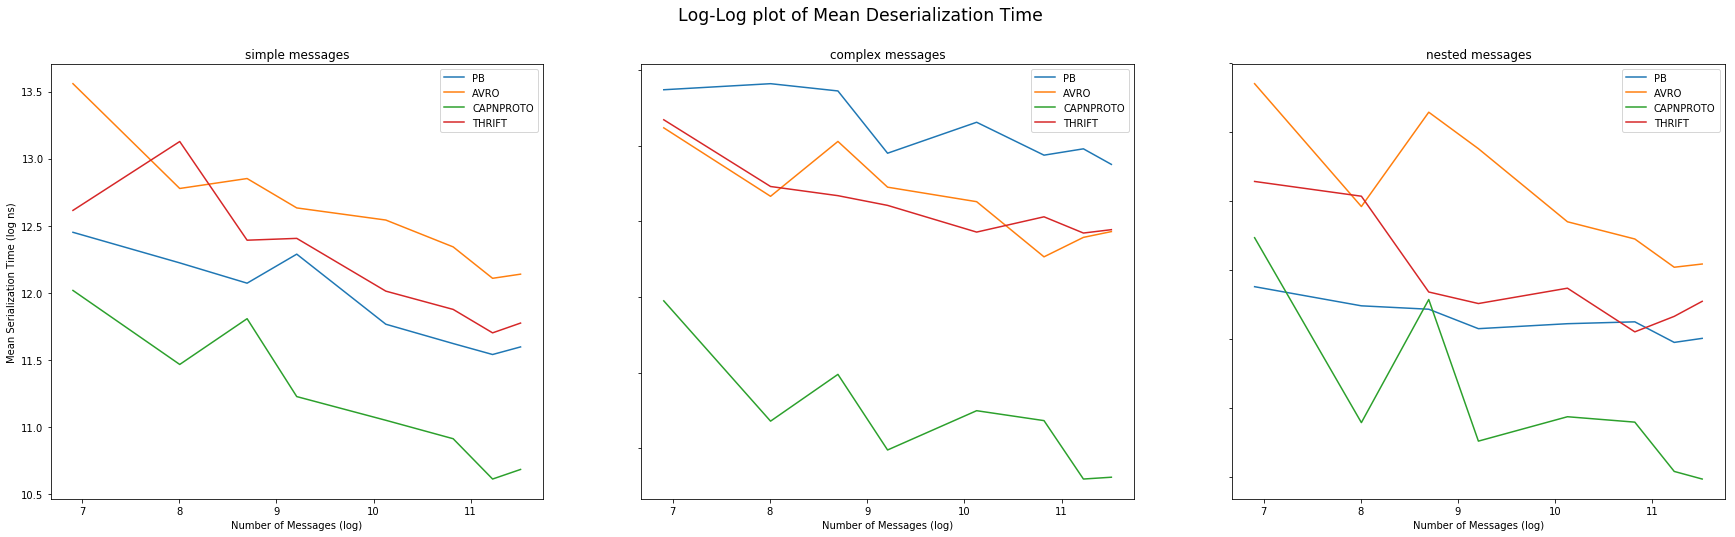

In [10]:
# Toggles
logplot = True # 
plot_median = False # Setting this to true will plot the median + the quantiles, setting it to false just plots the mean
time_type = "ser" # "ser" or "deser"
# time_type = "deser" # "ser" or "deser"

# Plots
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
for idx, msg_type in enumerate(message_types):
    for bin_type in binary_formats:
        temp = np.array([all_dataframes[(bin_type, msg_type, num)][time_type]["mean" if not plot_median else "median"] for num in message_nums])
        lower_percentile = np.array([all_dataframes[(bin_type, msg_type, num)][time_type]["25p"] for num in message_nums])
        higher_percentile = np.array([all_dataframes[(bin_type, msg_type, num)][time_type]["75p"] for num in message_nums])
        
        x_data = message_nums
        y_data = temp
        low_err = temp - lower_percentile
        high_err = higher_percentile - temp
        if logplot:
            x_data = np.log(x_data)
            y_data = np.log(y_data)
            low_err = np.log(temp) - np.log(lower_percentile)
            high_err = np.log(higher_percentile) - np.log(temp)
        
        if plot_median:
            axs[idx].errorbar(x_data,
                              y_data,
                              yerr=[low_err, high_err],
                              fmt="-",
                              capsize=5,
                              label=f"{bin_type}")
        else:
            axs[idx].plot(x_data,
                          y_data,
                          label=f"{bin_type}")

    axs[idx].set_title(f"{message_types_string[idx]} messages")
    axs[idx].legend()

for idx, ax in enumerate(axs.flat):
    label_x = "Number of Messages"
    if time_type == "ser":
        label_y = "Serialization Time"
    else:
        label_y = "Deserialization Time"
    if plot_median:
        label_y = "Median " + label_y
    else:
        label_y = "Mean " + label_y
    
    if logplot:
        label_x += " (log)"
        label_y += " (log ns)"
    else:
        label_y += " (ns)"
        
    ax.set(xlabel=label_x, ylabel=label_y)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.suptitle("Log-Log plot of Mean Deserialization Time", size="xx-large")
plt.show()

### Violin Plots

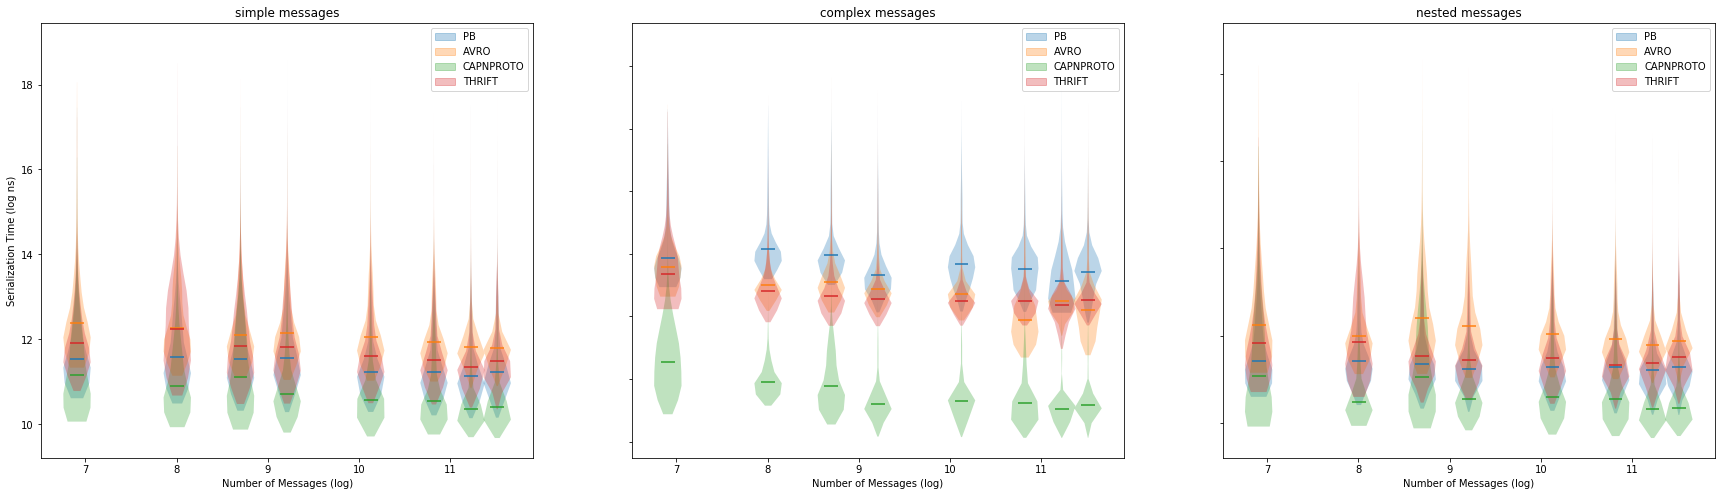

In [11]:
# Toggles
logplot = True # 
time_type = "ser" # "ser" or "deser"
# time_type = "deser" # "ser" or "deser"
plot_median = False # if true, plots medians, if false, plots means

# Plots
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
for idx, msg_type in enumerate(message_types):
    labels = []
    patches = []
    for bin_type in binary_formats:
        temp = np.array([all_dataframes[(bin_type, msg_type, num)][time_type]["data"] for num in message_nums])
        medians = np.array([all_dataframes[(bin_type, msg_type, num)][time_type]["median"] for num in message_nums])
        means = np.array([all_dataframes[(bin_type, msg_type, num)][time_type]["mean"] for num in message_nums])
        lower_percentile = np.array([all_dataframes[(bin_type, msg_type, num)][time_type]["25p"] for num in message_nums])
        higher_percentile = np.array([all_dataframes[(bin_type, msg_type, num)][time_type]["75p"] for num in message_nums])
        
        x_data = message_nums
        y_data = temp
        line_data = means
        if logplot:
            x_data = np.log(x_data)
            y_data = [np.log(_) for _ in y_data]
            medians = np.log(medians)
            means = np.log(means)
        if plot_median:
            line_data = medians
            
#         axs[idx].plot(x_data,
#                       line_data,
#                       label=f"{bin_type}")
        res = axs[idx].violinplot(y_data,
                            x_data,
                            points=20,
                            widths=0.3,
                            showmeans=(not plot_median),
                            showextrema=False,
                            showmedians=plot_median,
                            bw_method=0.5)
        face_color = tuple(res["bodies"][0].get_facecolor()[0])
        temp_patch = mpatches.Patch(color=face_color)
        patches.append(temp_patch)
        labels.append(f"{bin_type}")

    axs[idx].set_title(f"{message_types_string[idx]} messages")
    axs[idx].legend(patches, labels)

for idx, ax in enumerate(axs.flat):
    label_x = "Number of Messages"
    if time_type == "ser":
        label_y = "Serialization Time"
    else:
        label_y = "Deserialization Time"
    
    if logplot:
        label_x += " (log)"
        label_y += " (log ns)"
    else:
        label_y += " (ns)"
        
    ax.set(xlabel=label_x, ylabel=label_y)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

# Metrics Analysis

In [15]:
binary_formats = [
    "PB", 
    "AVRO", 
    "CAPNPROTO", 
    "AVRO_SCHEMAREG", 
    "THRIFT"
]

for bin_type in binary_formats:
    for msg_type, msg_num in message_combos:
        try:
            # Load in metrics as a list of dictionaries
            all_metrics[(bin_type, msg_type, msg_num)] = {}
            for client_type in ["consumer", "producer"]:
                all_metrics[(bin_type, msg_type, msg_num)][client_type] = []
                with open(f"data/{bin_type}{msg_type}_{msg_num}_{client_type}metrics.txt") as f:
                    for line in f:
                        metric = json.loads(line)
                        all_metrics[(bin_type, msg_type, msg_num)][client_type].append(metric)
                    
        except:
            print(bin_type, msg_type, msg_num)

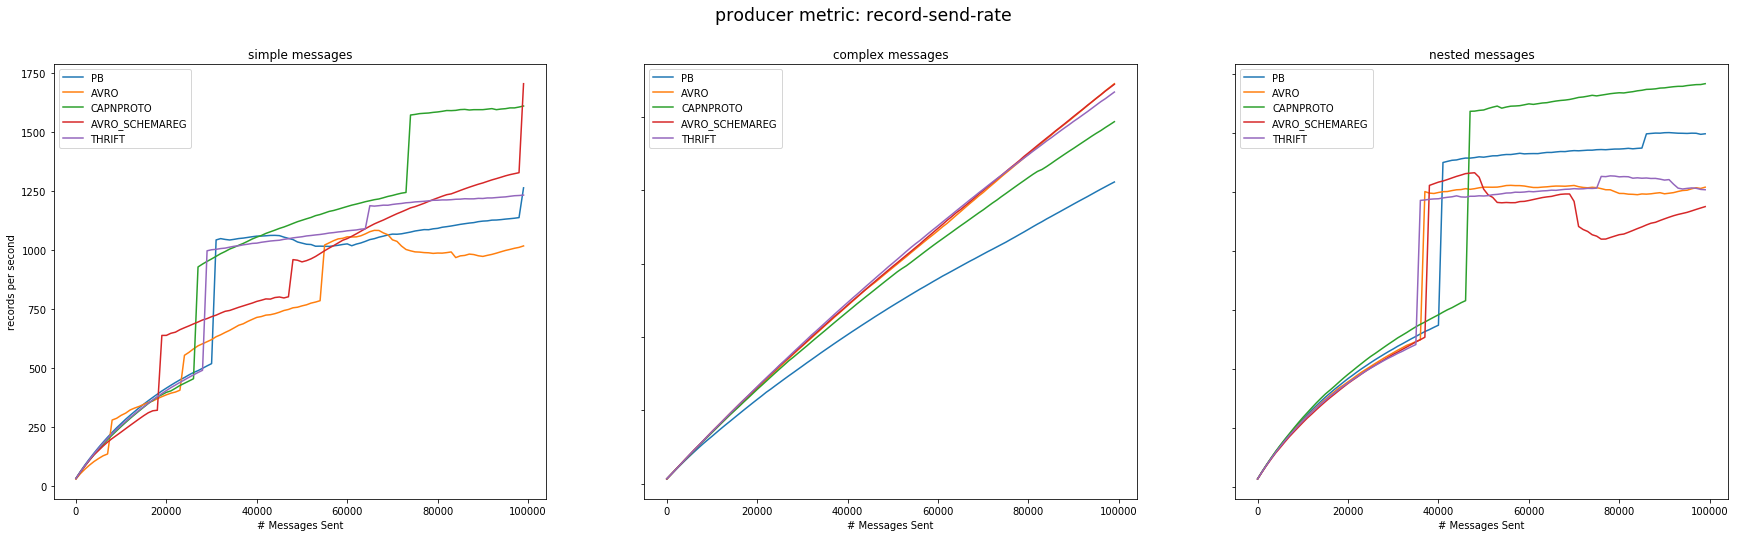

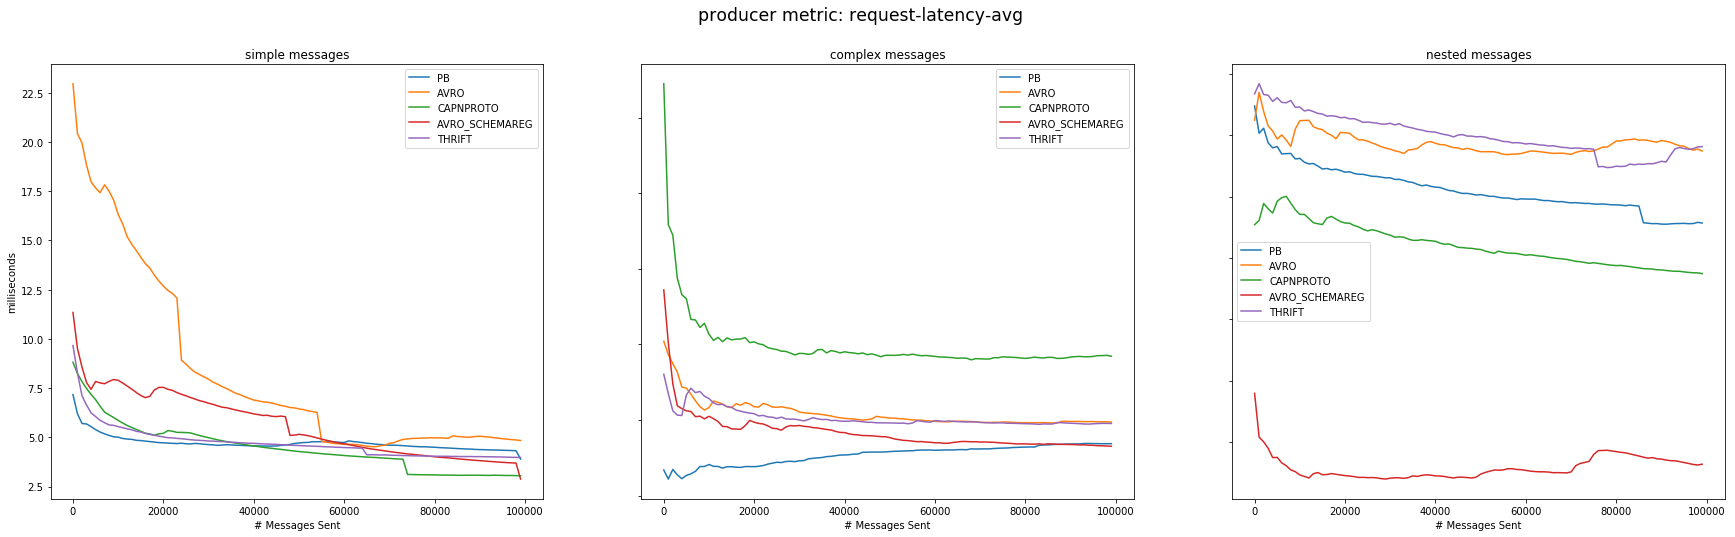

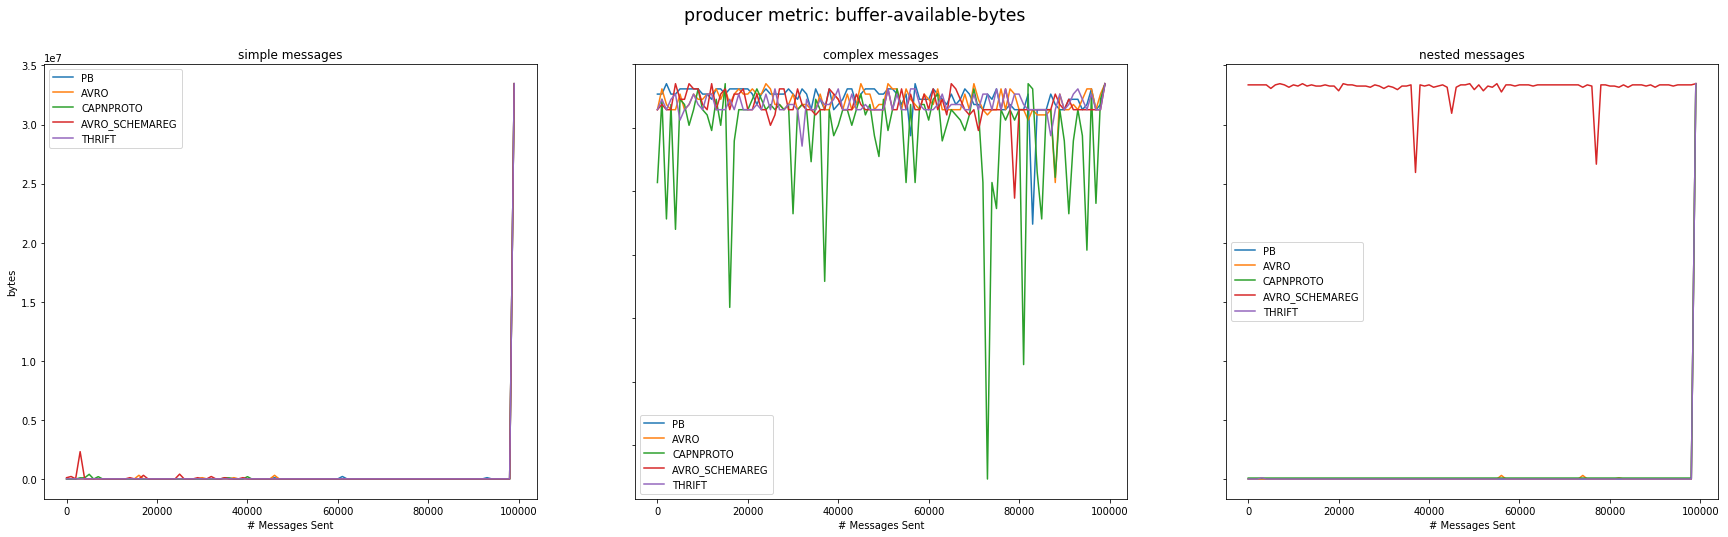

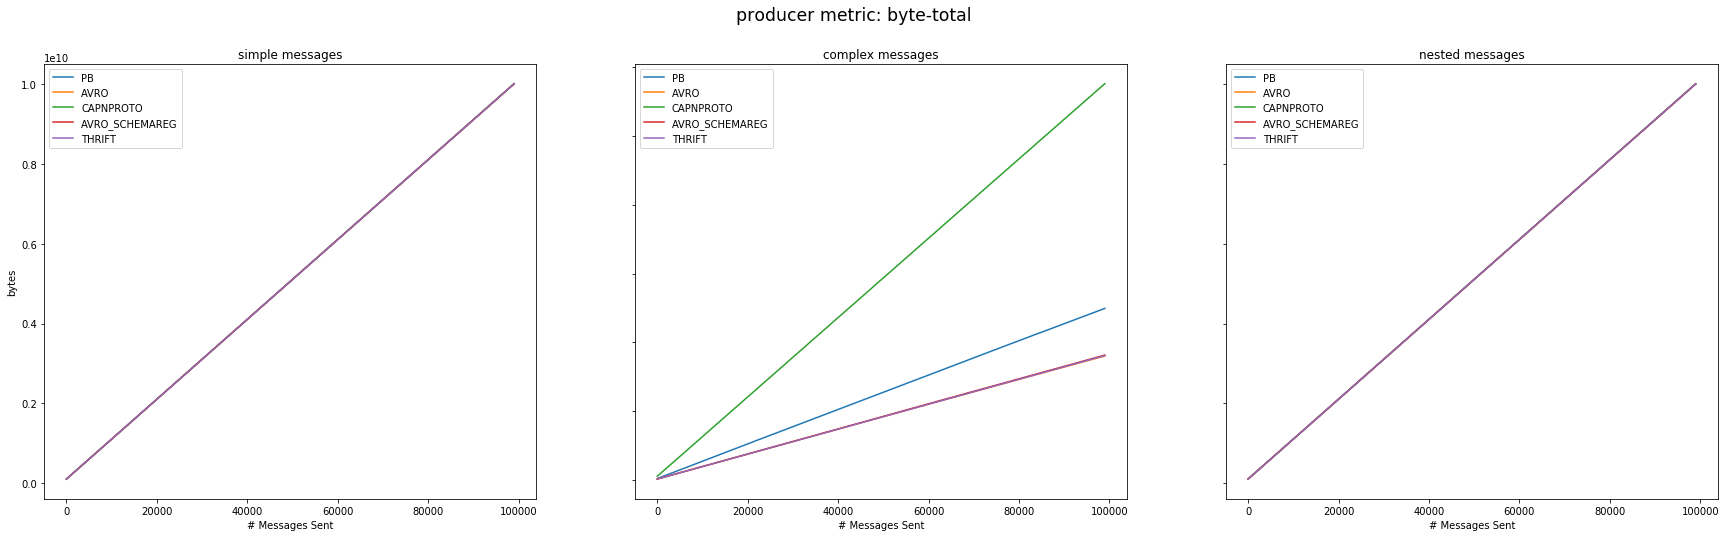

In [16]:
# Toggles
num = message_nums[-1] # This is currently set to view metrics from 100k iters

for metric_name, metric_unit in producer_metrics_units.items():
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    for idx, msg_type in enumerate(message_types):
        for bin_type in binary_formats:
            data = [_[metric_name] for _ in all_metrics[(bin_type, msg_type, num)]["producer"]]
            intervals = np.array(range(len(data))) * 1000
            axs[idx].plot(intervals,
                          data,
                          label=f"{bin_type}")
        axs[idx].set_title(f"{message_types_string[idx]} messages")
        axs[idx].legend()
        
    for idx, ax in enumerate(axs.flat):
        label_x = "# Messages Sent"
        label_y = metric_unit
        ax.set(xlabel=label_x, ylabel=label_y)
    for ax in axs.flat:
        ax.label_outer()
    plt.suptitle(f"producer metric: {metric_name}", size="xx-large")
    plt.show()

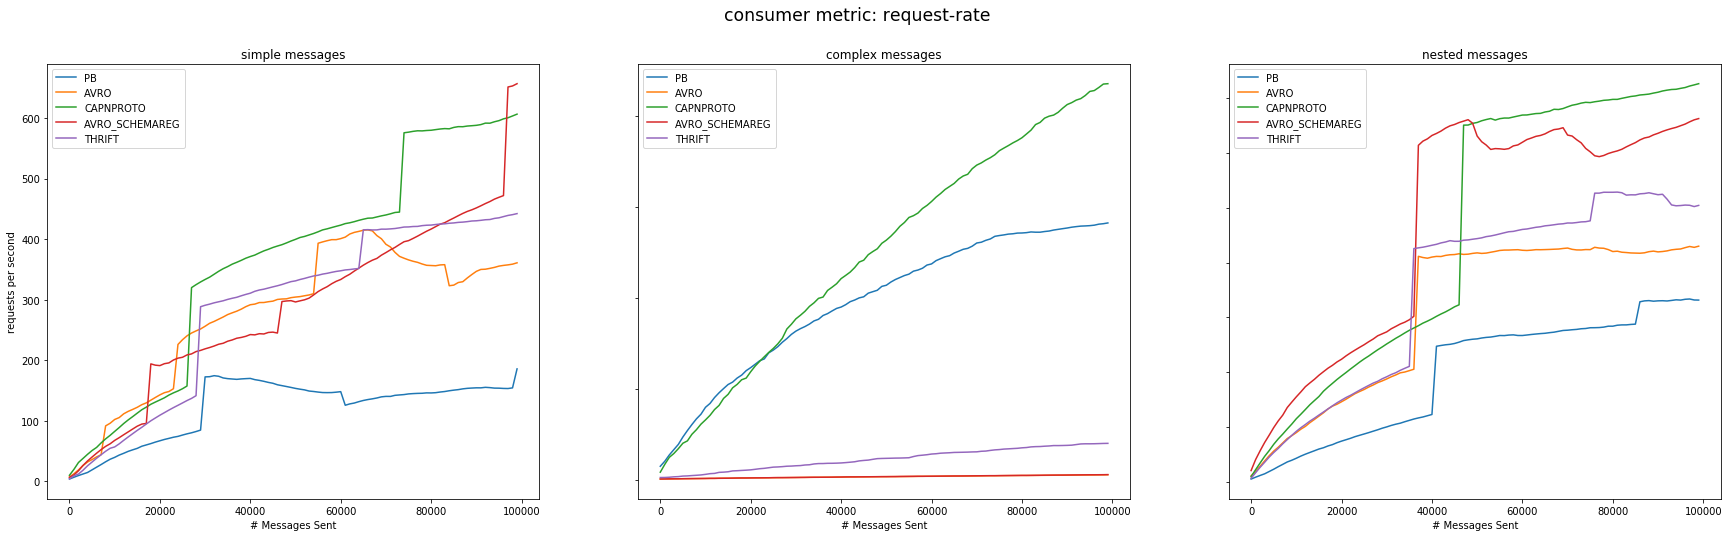

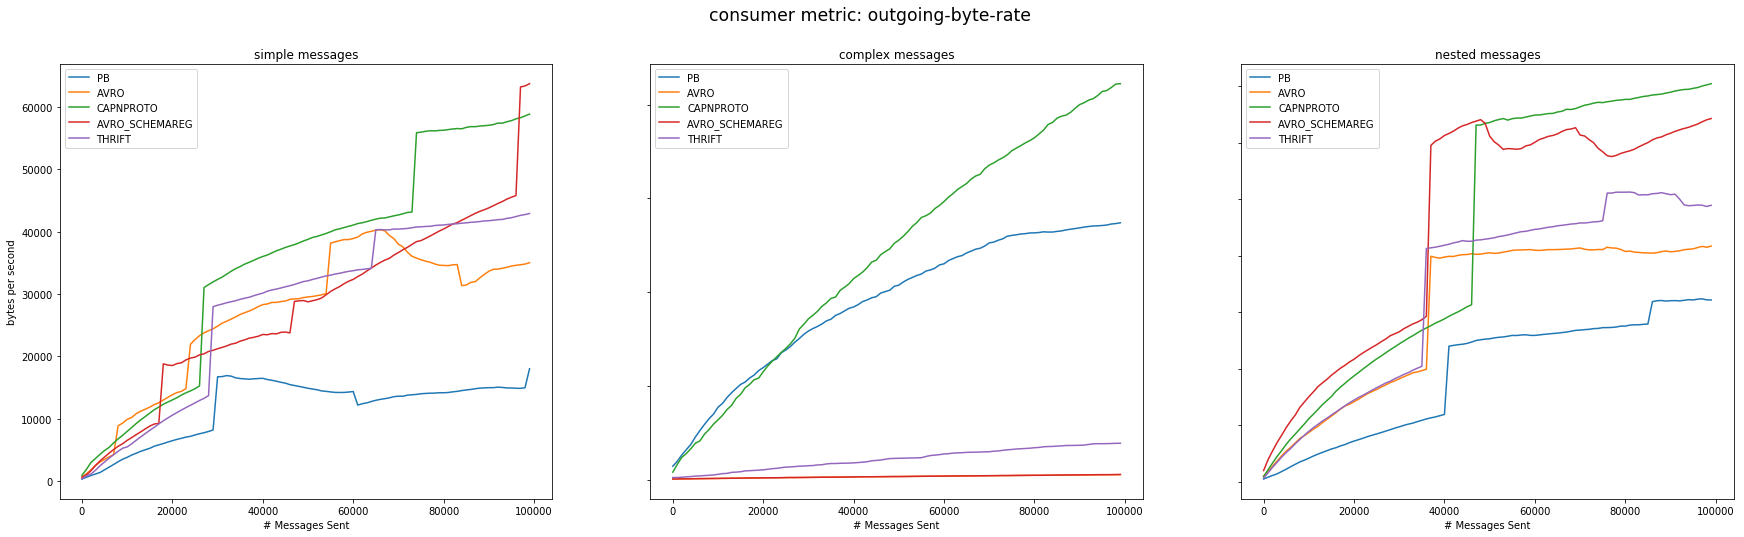

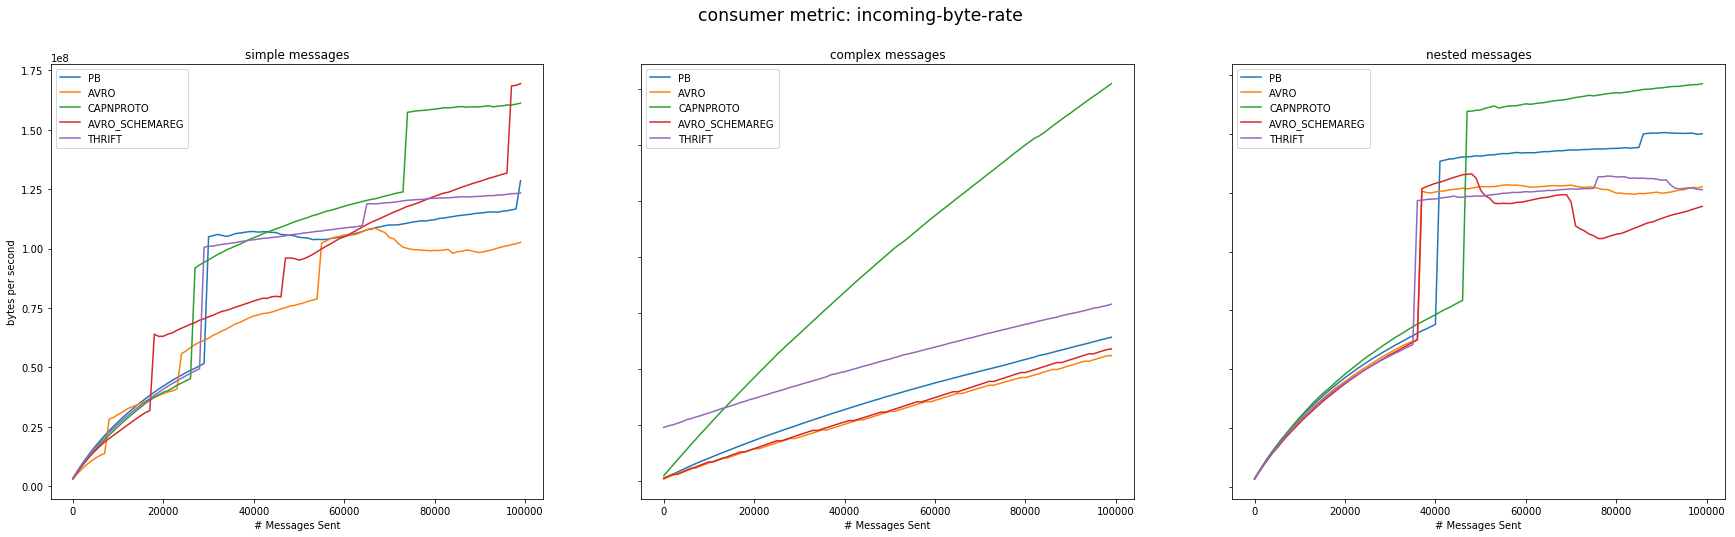

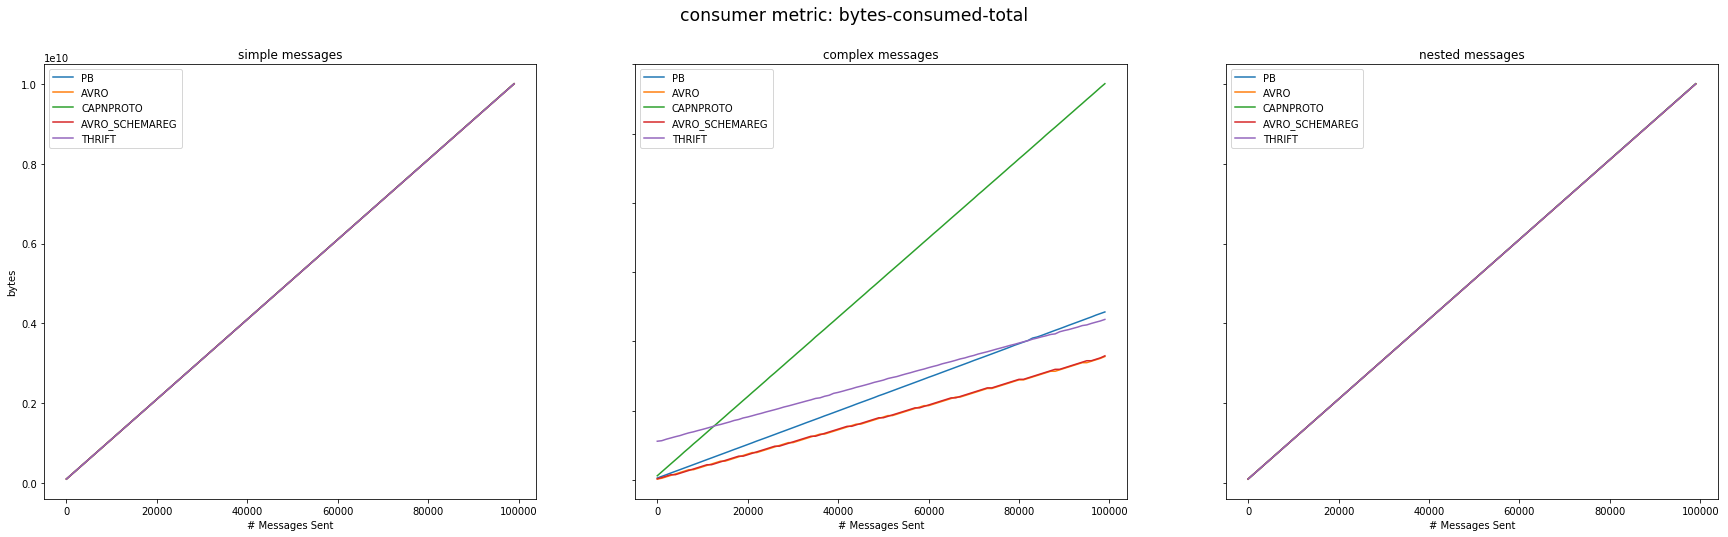

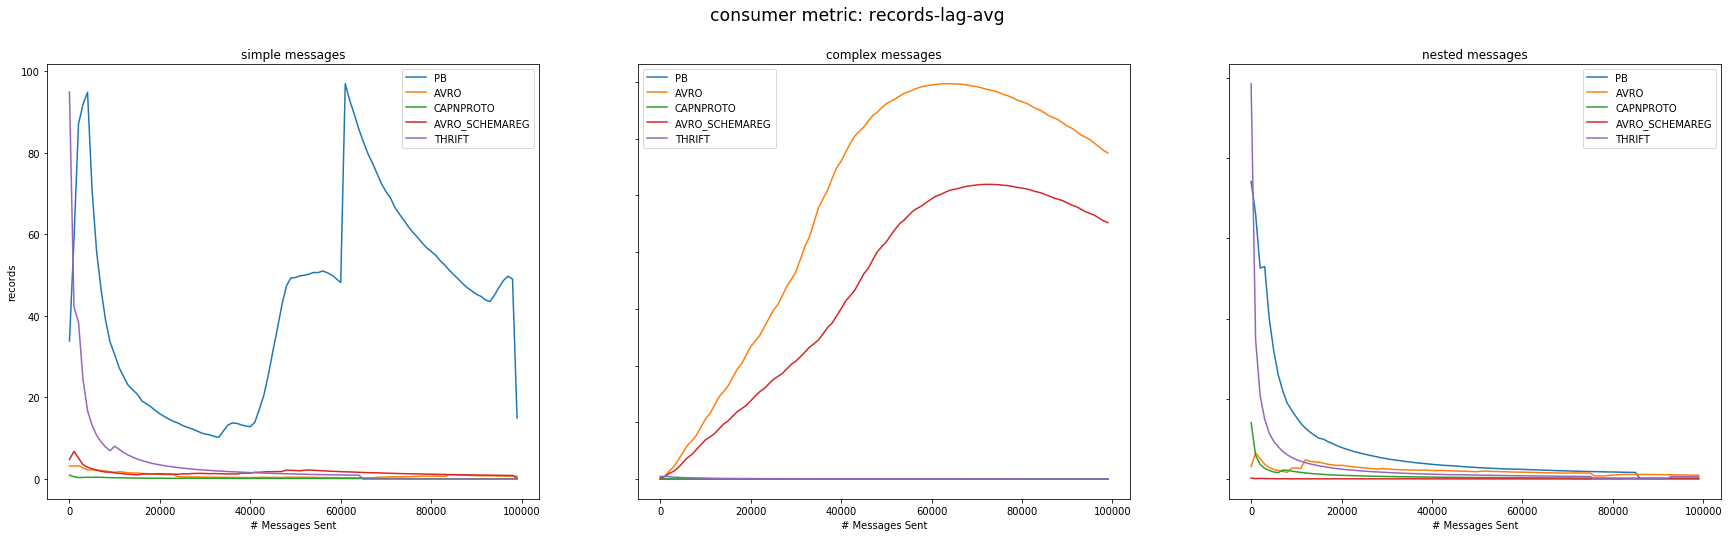

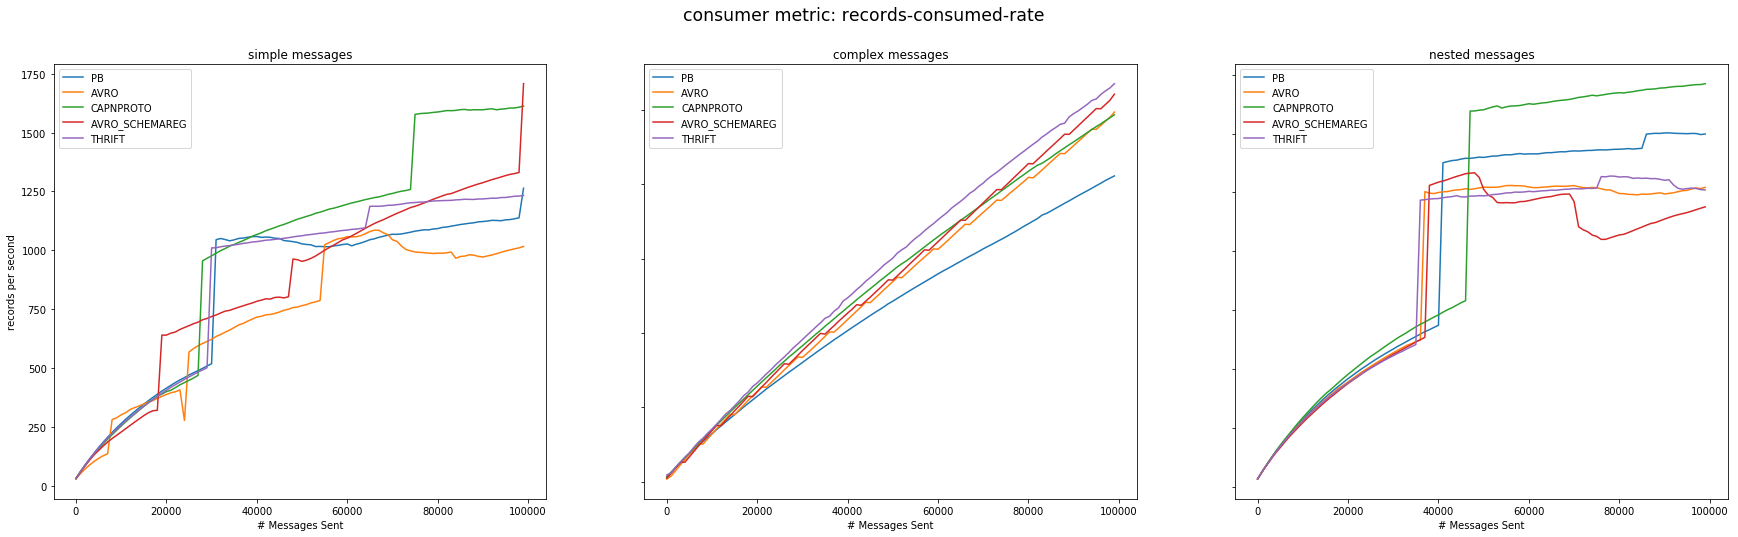

In [17]:
# Toggles
num = message_nums[-1] # This is currently set to view metrics from 100k iters

for metric_name, metric_unit in consumer_metrics_units.items():
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    for idx, msg_type in enumerate(message_types):
        for bin_type in binary_formats:
            data = [_[metric_name] for _ in all_metrics[(bin_type, msg_type, num)]["consumer"]]
            intervals = np.array(range(len(data))) * 1000
            axs[idx].plot(intervals,
                          data,
                          label=f"{bin_type}")
        axs[idx].set_title(f"{message_types_string[idx]} messages")
        axs[idx].legend()
        
    for idx, ax in enumerate(axs.flat):
        label_x = "# Messages Sent"
        label_y = metric_unit
        ax.set(xlabel=label_x, ylabel=label_y)
    for ax in axs.flat:
        ax.label_outer()
    plt.suptitle(f"consumer metric: {metric_name}", size="xx-large")
    plt.show()

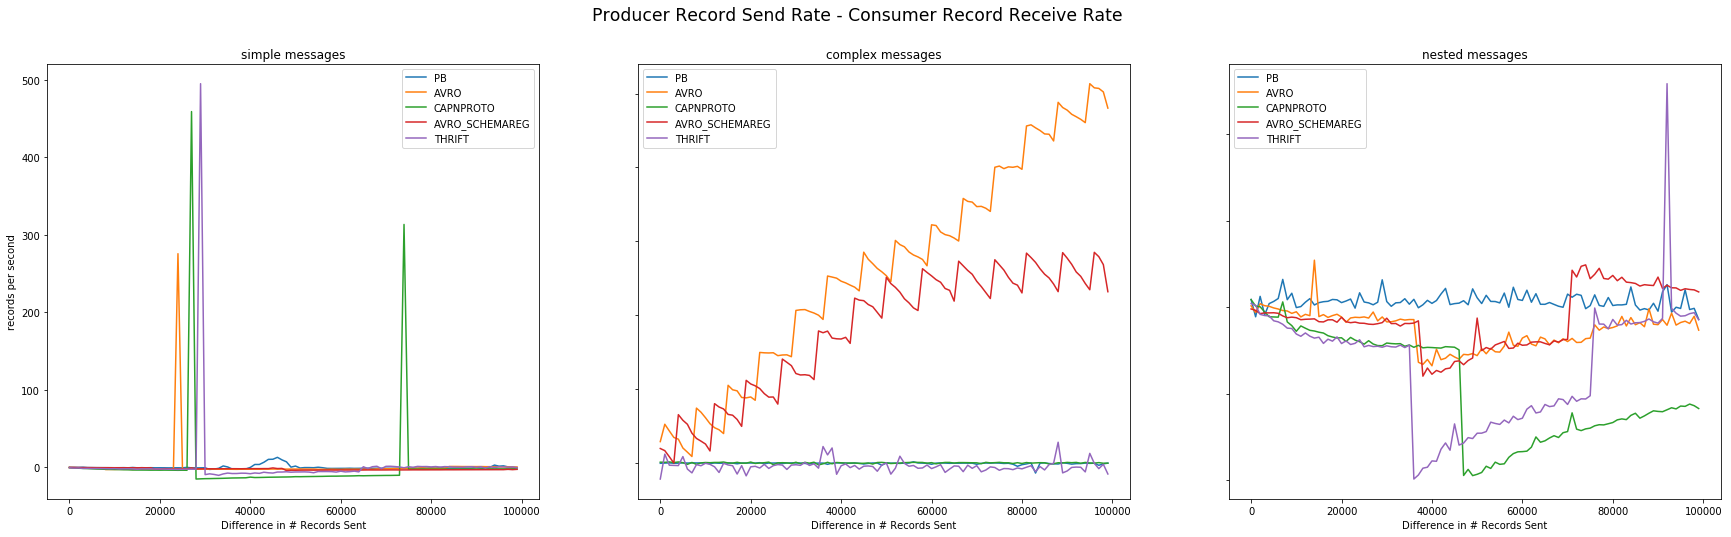

In [18]:
# Toggles
num = message_nums[-1] # This is currently set to view metrics from 100k iters

fig, axs = plt.subplots(1, 3, figsize=(30, 8))
for idx, msg_type in enumerate(message_types):
    for bin_type in binary_formats:
        consumer_data = np.array([_["records-consumed-rate"] for _ in all_metrics[(bin_type, msg_type, num)]["consumer"]])
        producer_data = np.array([_["record-send-rate"] for _ in all_metrics[(bin_type, msg_type, num)]["producer"]])
        intervals = np.array(range(len(data))) * 1000
        axs[idx].plot(intervals,
                      producer_data - consumer_data,
                      label=f"{bin_type}")
    axs[idx].set_title(f"{message_types_string[idx]} messages")
    axs[idx].legend()

for idx, ax in enumerate(axs.flat):
    label_x = "Difference in # Records Sent"
    label_y = metric_unit
    ax.set(xlabel=label_x, ylabel=label_y)
for ax in axs.flat:
    ax.label_outer()
plt.suptitle(f"Producer Record Send Rate - Consumer Record Receive Rate", size="xx-large")
plt.show()

# Avro vs Schema Reg Consumer

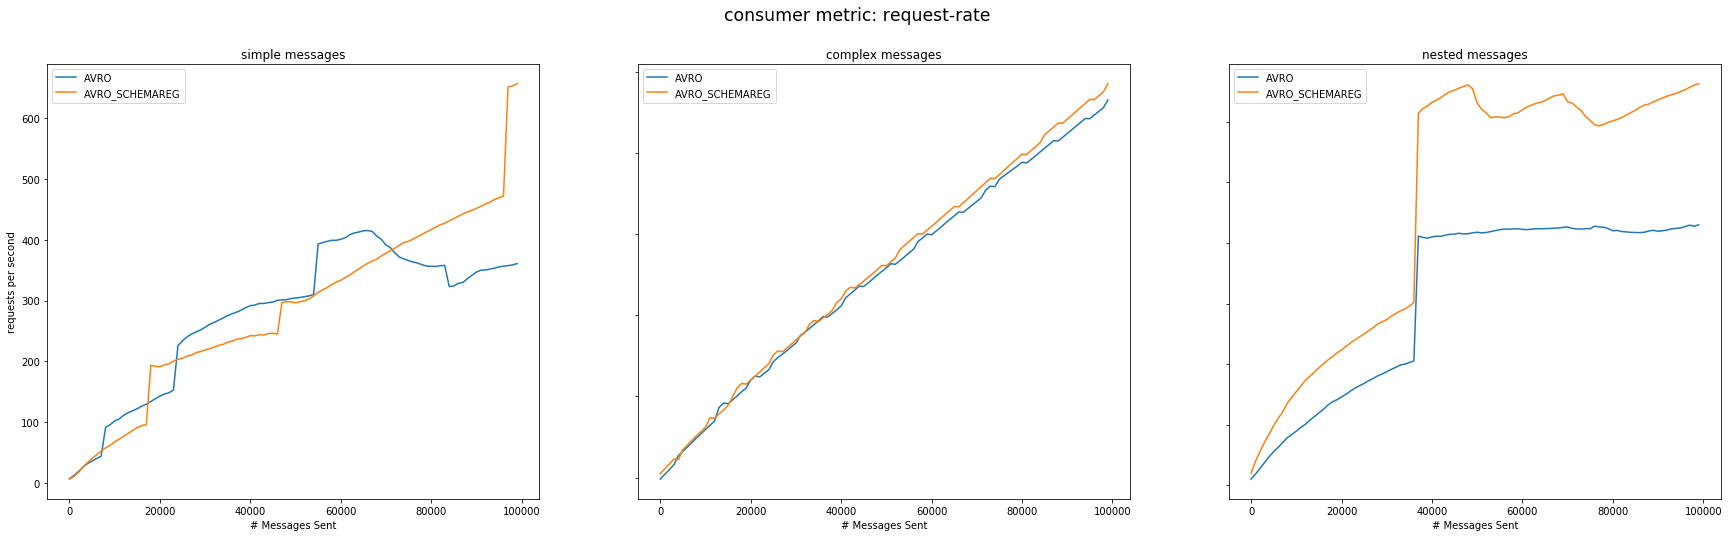

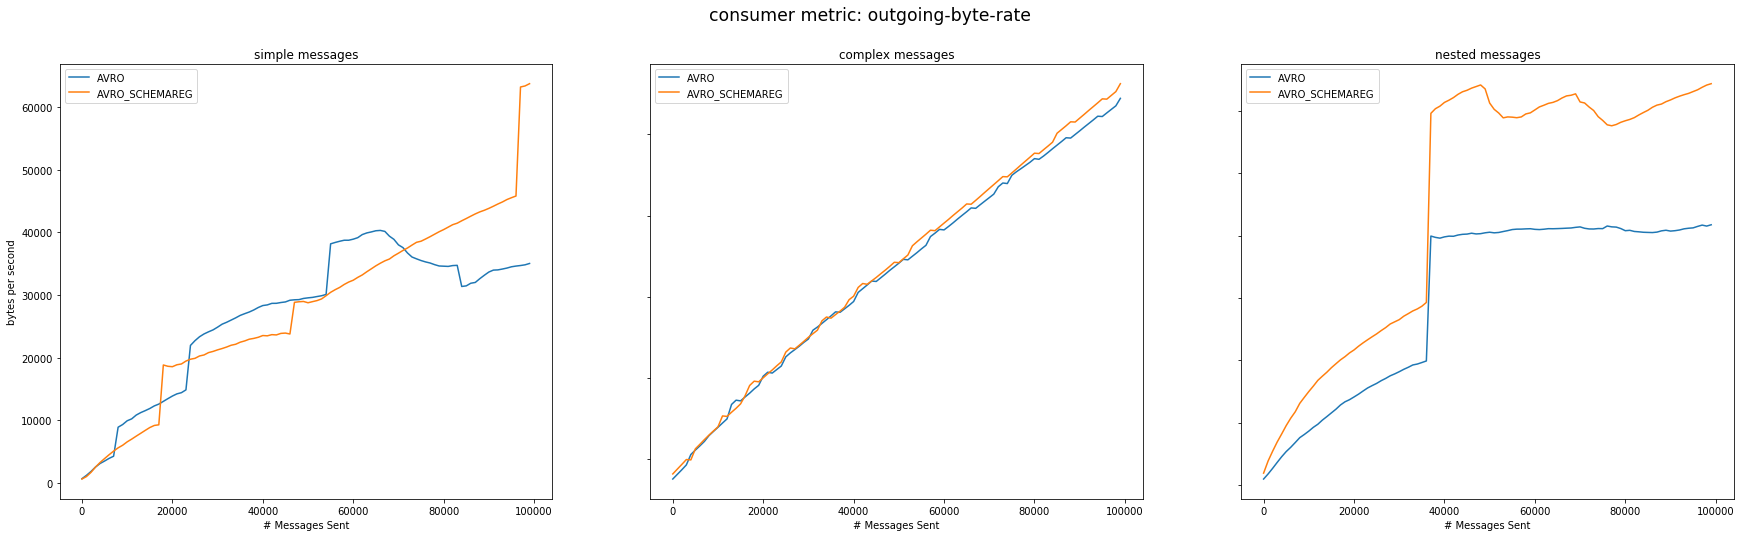

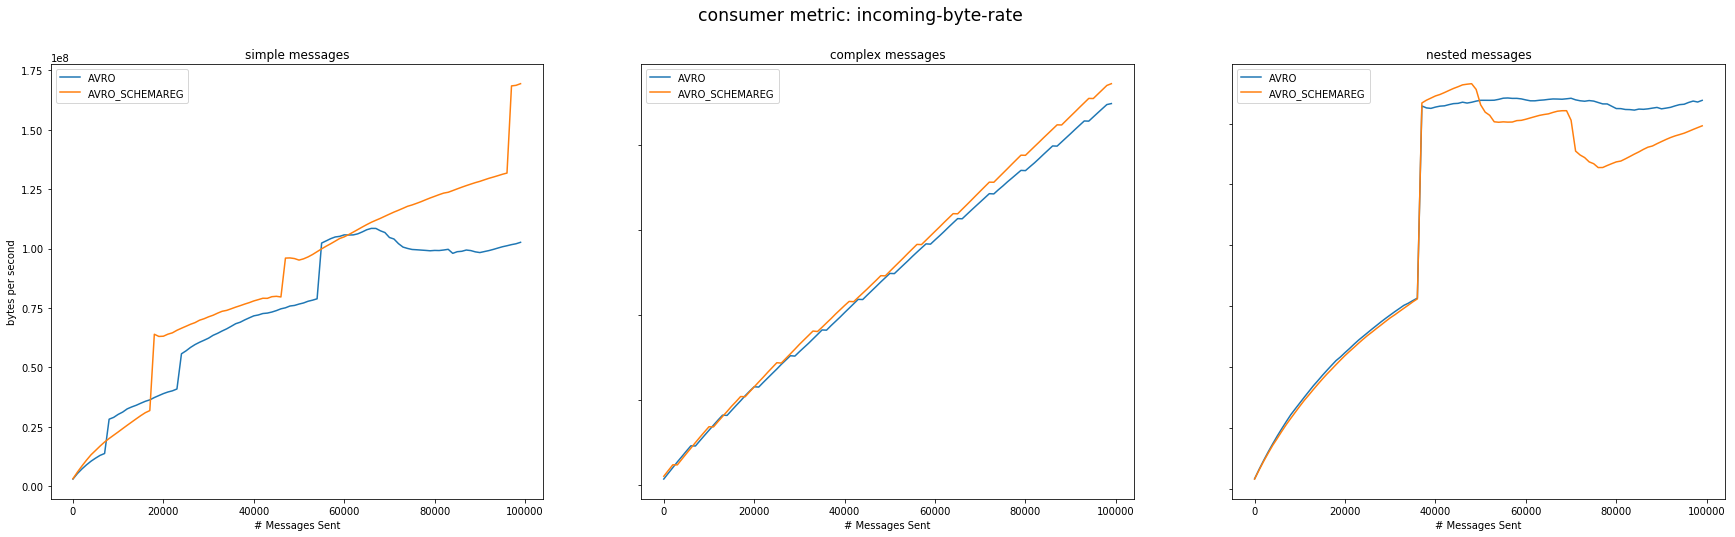

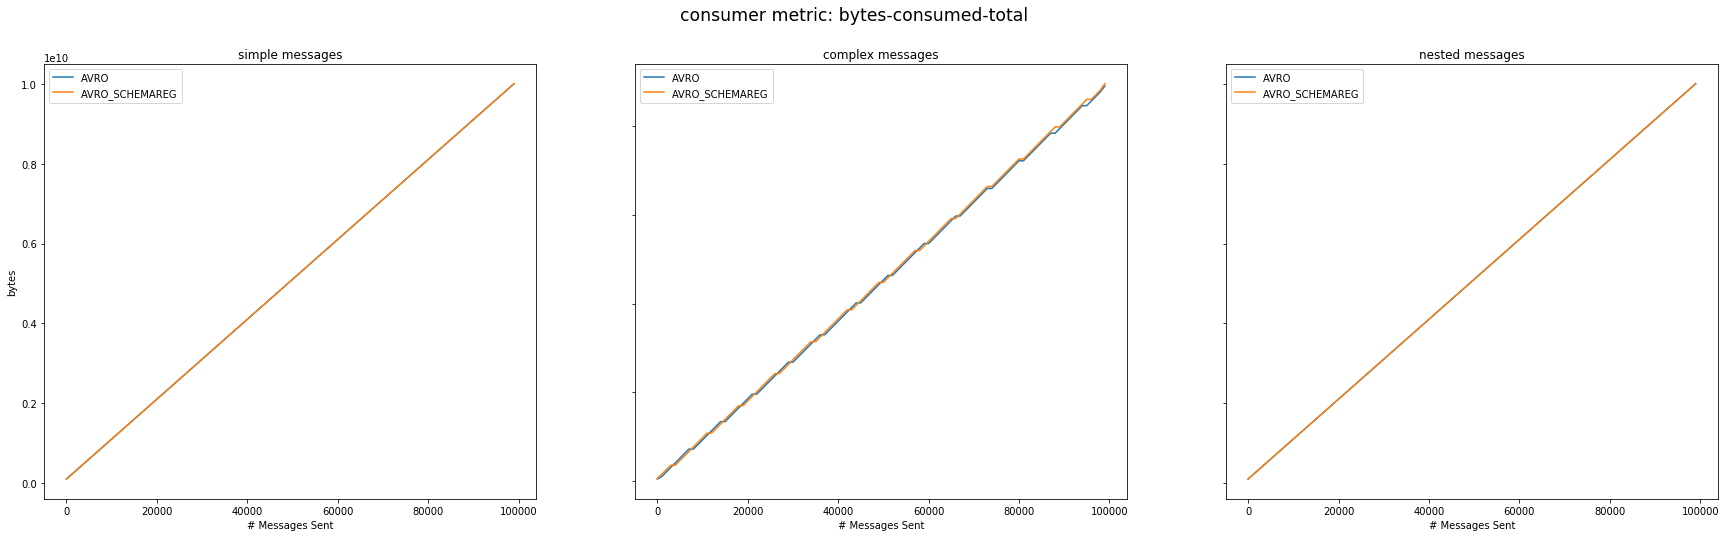

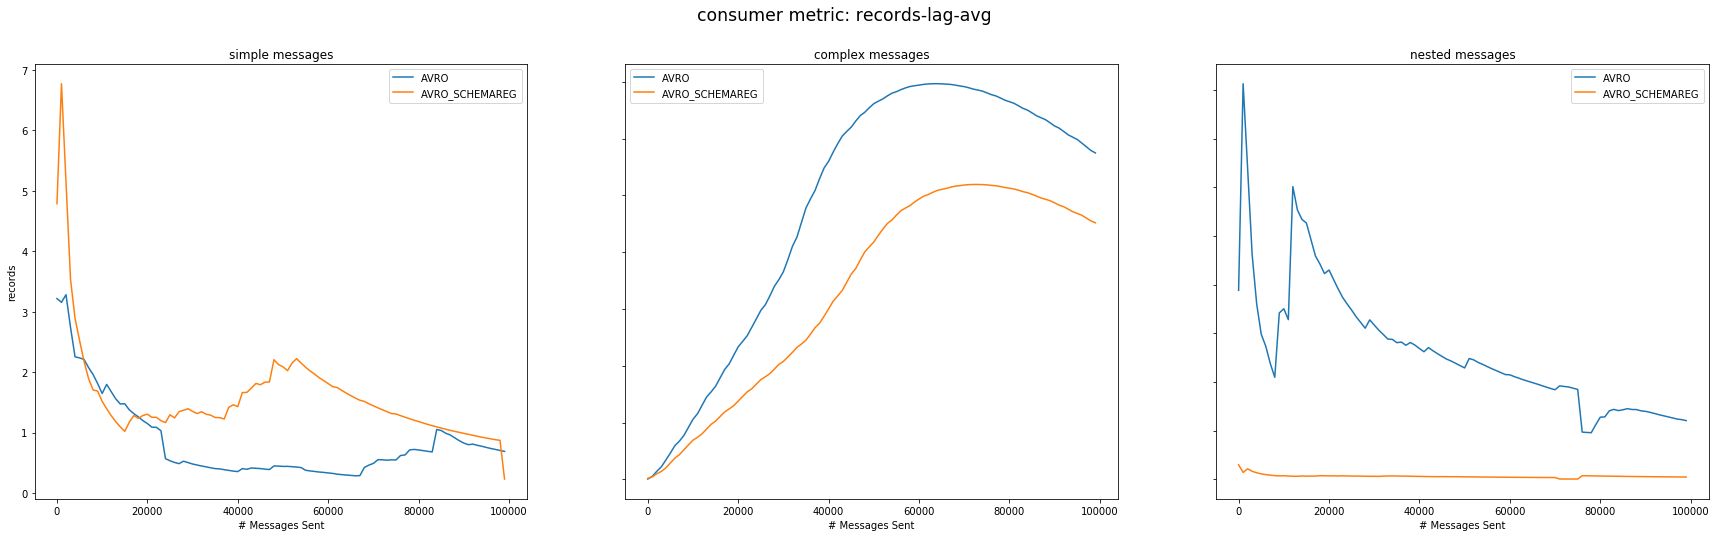

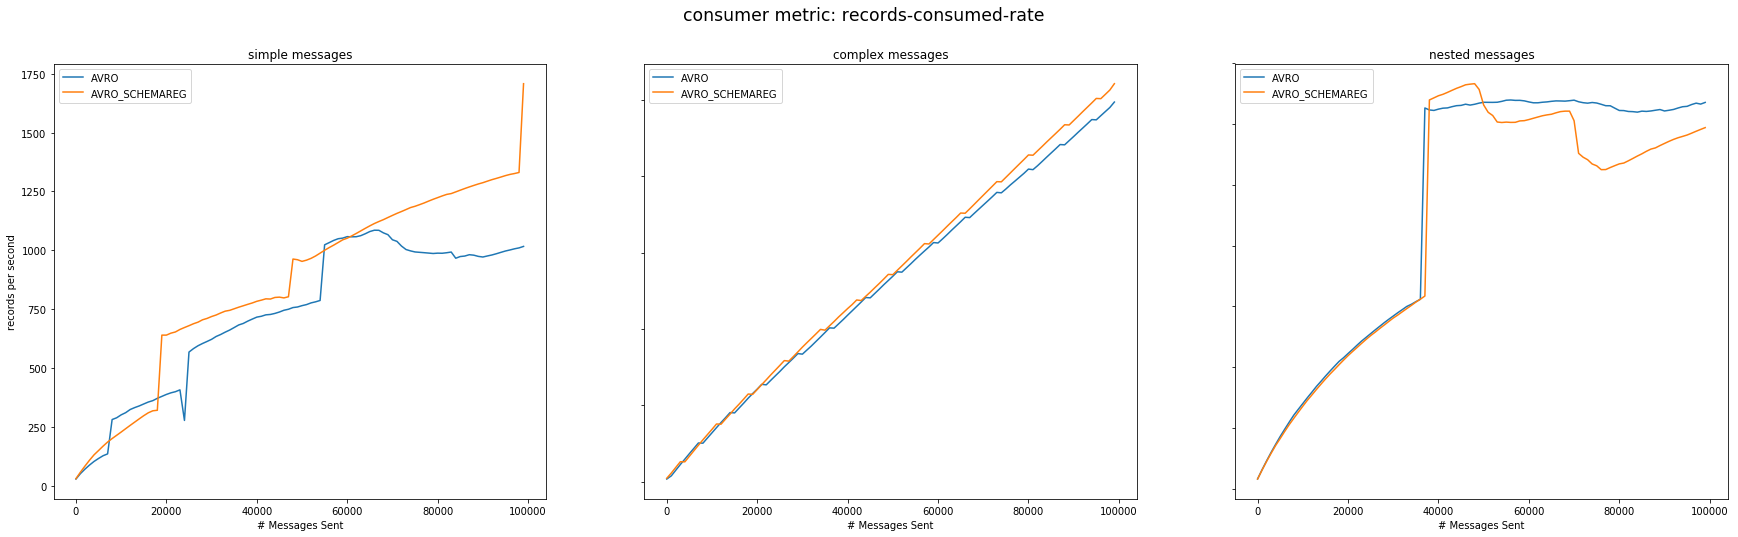

In [19]:
# Toggles
num = message_nums[-1] # This is currently set to view metrics from 100k iters

for metric_name, metric_unit in consumer_metrics_units.items():
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    for idx, msg_type in enumerate(message_types):
        for bin_type in binary_formats:
            if bin_type == "AVRO" or bin_type == "AVRO_SCHEMAREG":
                data = [_[metric_name] for _ in all_metrics[(bin_type, msg_type, num)]["consumer"]]
                intervals = np.array(range(len(data))) * 1000
                axs[idx].plot(intervals,
                              data,
                              label=f"{bin_type}")
        axs[idx].set_title(f"{message_types_string[idx]} messages")
        axs[idx].legend()
        
    for idx, ax in enumerate(axs.flat):
        label_x = "# Messages Sent"
        label_y = metric_unit
        ax.set(xlabel=label_x, ylabel=label_y)
    for ax in axs.flat:
        ax.label_outer()
    plt.suptitle(f"consumer metric: {metric_name}", size="xx-large")
    plt.show()

# Avro vs Schema Reg Producer

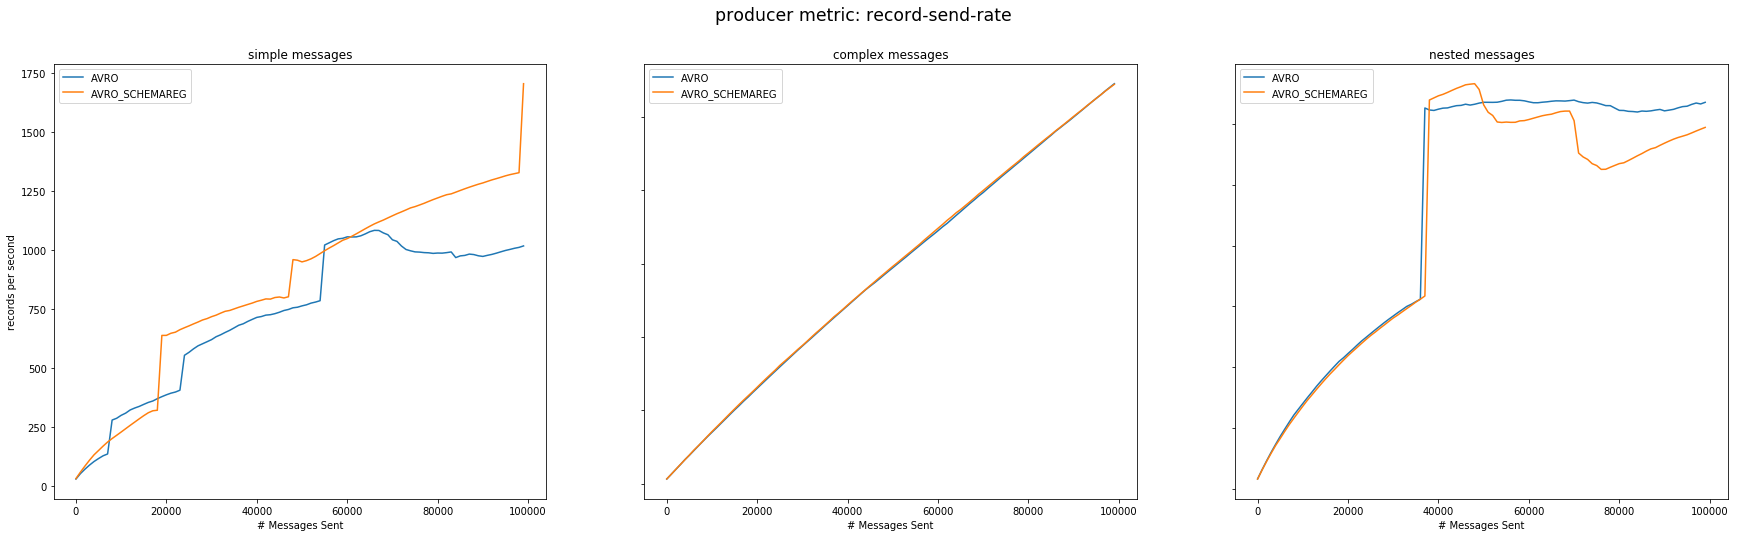

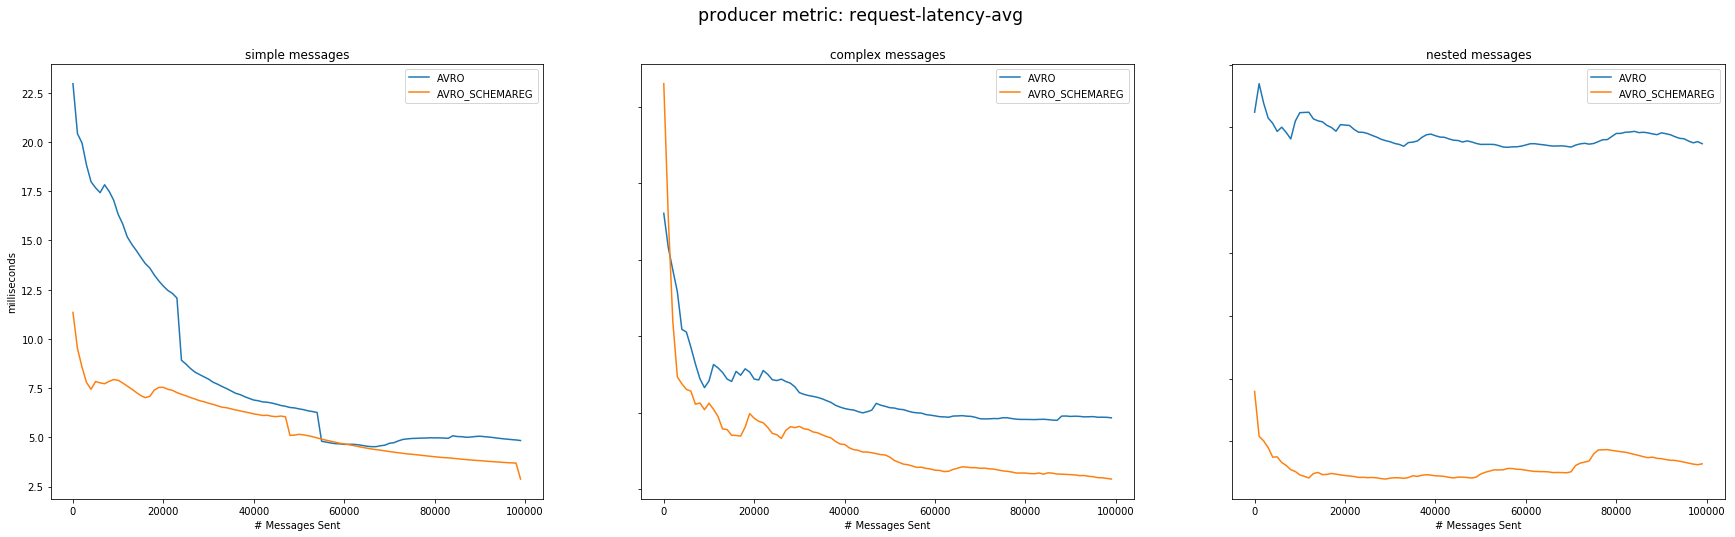

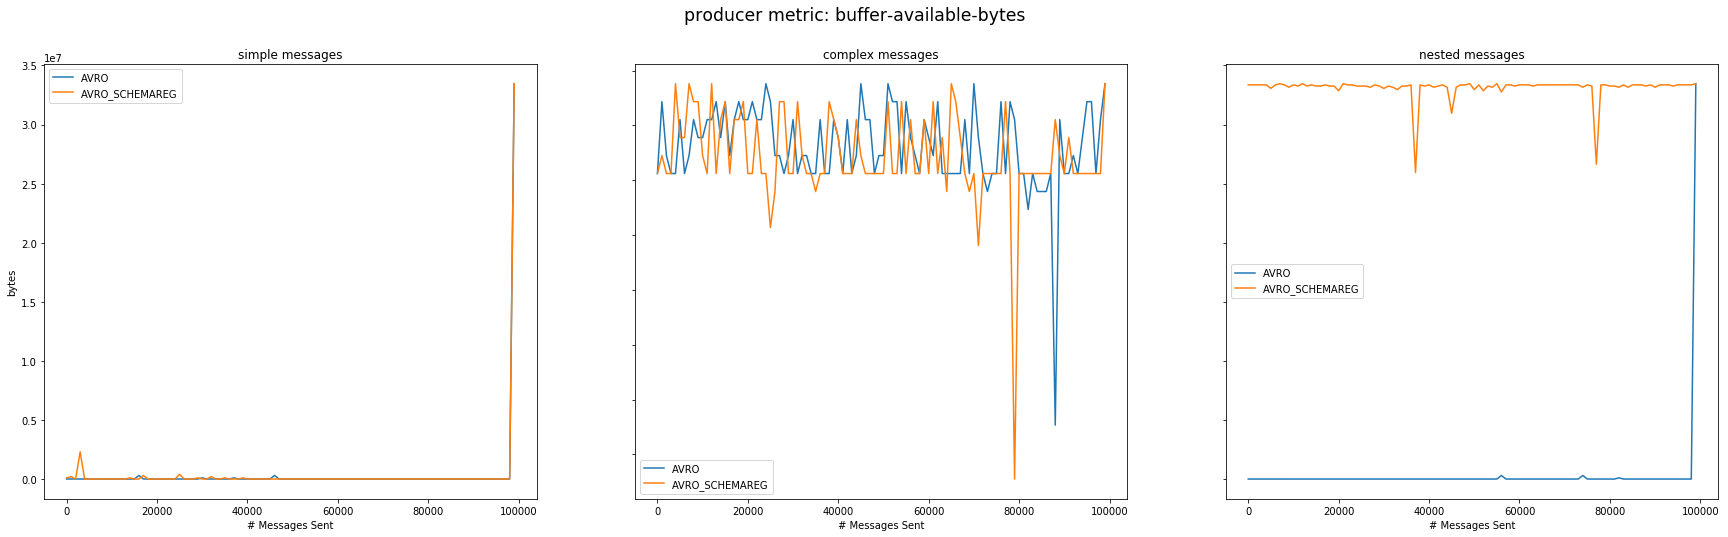

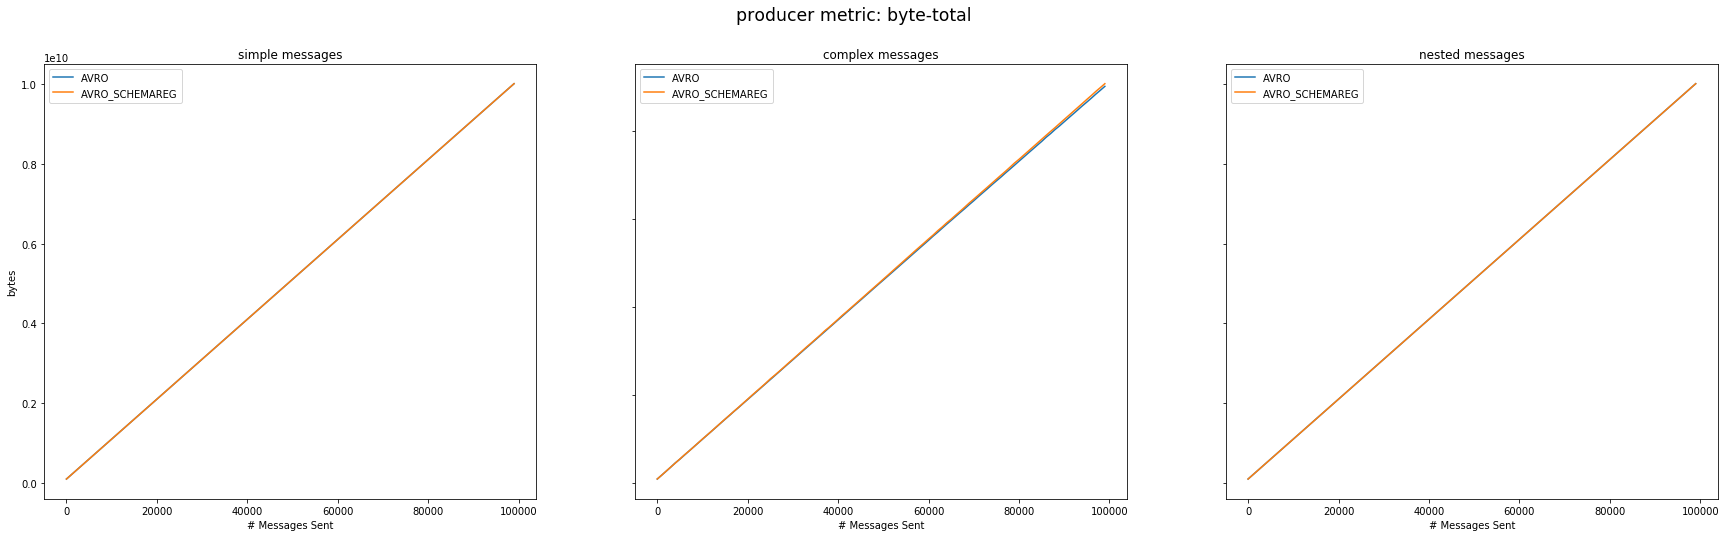

In [20]:
# Toggles
num = message_nums[-1] # This is currently set to view metrics from 100k iters

for metric_name, metric_unit in producer_metrics_units.items():
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    for idx, msg_type in enumerate(message_types):
        for bin_type in binary_formats:
            if bin_type == "AVRO" or bin_type == "AVRO_SCHEMAREG":
                data = [_[metric_name] for _ in all_metrics[(bin_type, msg_type, num)]["producer"]]
                intervals = np.array(range(len(data))) * 1000
                axs[idx].plot(intervals,
                              data,
                              label=f"{bin_type}")
        axs[idx].set_title(f"{message_types_string[idx]} messages")
        axs[idx].legend()
        
    for idx, ax in enumerate(axs.flat):
        label_x = "# Messages Sent"
        label_y = metric_unit
        ax.set(xlabel=label_x, ylabel=label_y)
    for ax in axs.flat:
        ax.label_outer()
    plt.suptitle(f"producer metric: {metric_name}", size="xx-large")
    plt.show()

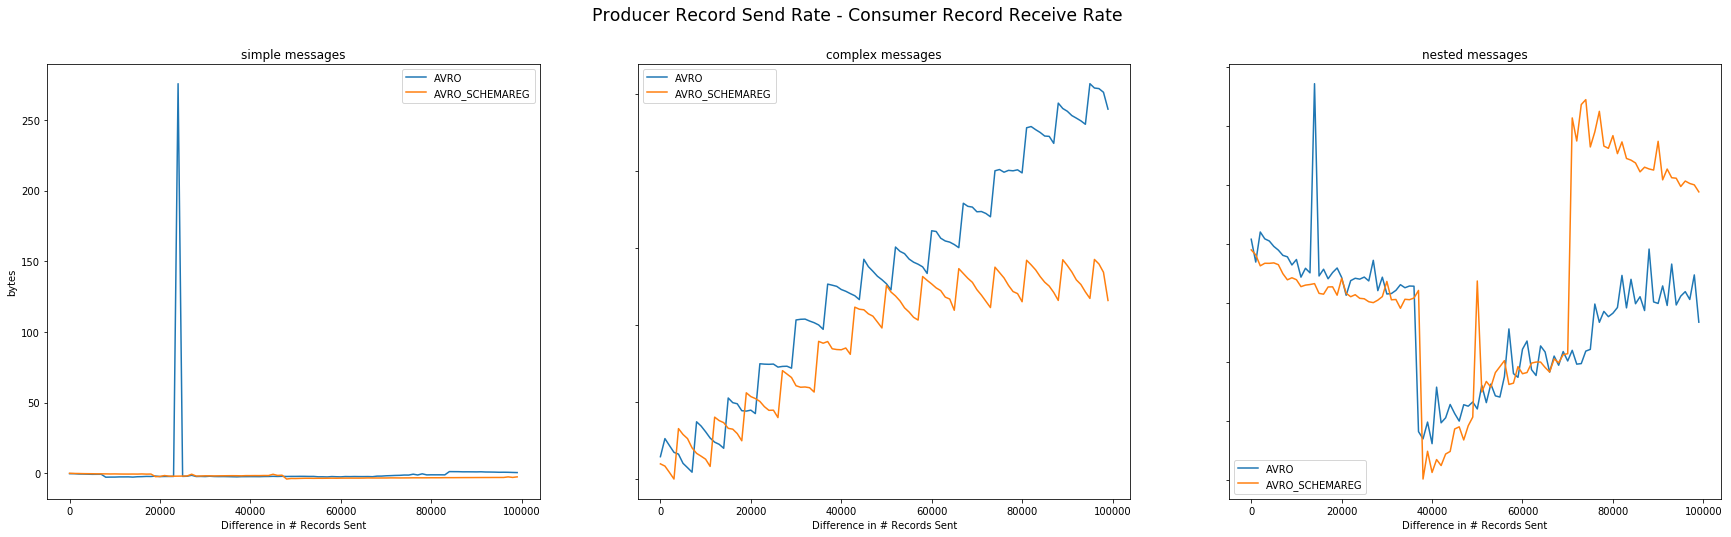

In [21]:
# Toggles
num = message_nums[-1] # This is currently set to view metrics from 100k iters

fig, axs = plt.subplots(1, 3, figsize=(30, 8))
for idx, msg_type in enumerate(message_types):
    for bin_type in binary_formats:
        if bin_type == "AVRO" or bin_type == "AVRO_SCHEMAREG":
            consumer_data = np.array([_["records-consumed-rate"] for _ in all_metrics[(bin_type, msg_type, num)]["consumer"]])
            producer_data = np.array([_["record-send-rate"] for _ in all_metrics[(bin_type, msg_type, num)]["producer"]])
            intervals = np.array(range(len(data))) * 1000
            axs[idx].plot(intervals,
                          producer_data - consumer_data,
                          label=f"{bin_type}")
    axs[idx].set_title(f"{message_types_string[idx]} messages")
    axs[idx].legend()

for idx, ax in enumerate(axs.flat):
    label_x = "Difference in # Records Sent"
    label_y = metric_unit
    ax.set(xlabel=label_x, ylabel=label_y)
for ax in axs.flat:
    ax.label_outer()
plt.suptitle(f"Producer Record Send Rate - Consumer Record Receive Rate", size="xx-large")
plt.show()